In [592]:
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import spacy
import re
from nltk.stem.wordnet import WordNetLemmatizer
import markovify
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.text import Text
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
!python -m spacy download en
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from datetime import datetime as dt



✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/en_core_web_sm -->
/Users/robholmstrom/miniconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


## About dataset:
In response to the COVID-19 pandemic, a free resource of over 7,000 news articles from Canada with full text, about COVID-19 and the coronavirus family of viruses for use by the global research community.

This dataset is intended to mobilize researchers to apply recent advances in natural language processing to generate new insights in support of the fight against this infectious disease and future pandemics. The news articles will be updated weekly and more news agencies covering more countries will be continuously added at a later date.

https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26

In [593]:
df = pd.read_csv('/Users/robholmstrom/OneDrive/Gitrepos/nonrepo_files/news.csv')

In [594]:
df.head()

,Unnamed: 0,authors,title,publish_date,description,text,url
0,0,[],'More vital now:' Gay-straight alliances go vi...,2020-05-03 1:30,Lily Overacker and Laurell Pallot start each g...,Lily Overacker and Laurell Pallot start each g...,https://www.cbc.ca/news/canada/calgary/gay-str...
1,1,[],Scientists aim to 'see' invisible transmission...,2020-05-02 8:00,Some researchers aim to learn more about how t...,"This is an excerpt from Second Opinion, a week...",https://www.cbc.ca/news/technology/droplet-tra...
2,2,['The Canadian Press'],Coronavirus: What's happening in Canada and ar...,2020-05-02 11:28,Canada's chief public health officer struck an...,The latest: The lives behind the numbers: Wha...,https://www.cbc.ca/news/canada/coronavirus-cov...
3,3,[],"B.C. announces 26 new coronavirus cases, new c...",2020-05-02 18:45,B.C. provincial health officer Dr. Bonnie Henr...,B.C. provincial health officer Dr. Bonnie Henr...,https://www.cbc.ca/news/canada/british-columbi...
4,4,[],"B.C. announces 26 new coronavirus cases, new c...",2020-05-02 18:45,B.C. provincial health officer Dr. Bonnie Henr...,B.C. provincial health officer Dr. Bonnie Henr...,https://www.cbc.ca/news/canada/british-columbi...


In [595]:
#drop nulls since there are so few

df.dropna(inplace=True)

In [672]:
#get rid of duplicates
df.drop_duplicates(inplace= True)

In [673]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 0 to 6787
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    6770 non-null   object        
 1   authors       6770 non-null   object        
 2   title         6770 non-null   object        
 3   publish_date  6770 non-null   datetime64[ns]
 4   description   6770 non-null   object        
 5   text          6770 non-null   object        
 6   url           6770 non-null   object        
 7   date          6770 non-null   object        
 8   weekday       6770 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 528.9+ KB


In [674]:
#investigate the string structure before stripping the bracket and quotes
df.authors[2]

'The Canadian Press'

In [675]:
# Strip unnecessary character from string object:
df.authors = df.authors.str.strip("[]'")
df.title = df.title.str.strip("'")

In [676]:
# Convert time string to datetime
df.publish_date = pd.to_datetime(df.publish_date)

In [677]:
# Make column with just string
df['date'] = df.publish_date.dt.date

In [678]:
# Make column with just weekday name
df['weekday'] = df['publish_date'].dt.day_name()

In [679]:
df.head(2)

,Unnamed: 0,authors,title,publish_date,description,text,url,date,weekday
0,0,,More vital now:' Gay-straight alliances go vir...,2020-05-03 01:30:00,Lily Overacker and Laurell Pallot start each g...,Lily Overacker and Laurell Pallot start each g...,https://www.cbc.ca/news/canada/calgary/gay-str...,2020-05-03,Sunday
1,1,,Scientists aim to 'see' invisible transmission...,2020-05-02 08:00:00,Some researchers aim to learn more about how t...,"This is an excerpt from Second Opinion, a week...",https://www.cbc.ca/news/technology/droplet-tra...,2020-05-02,Saturday


In [680]:
# check counts for years included for articles
df['publish_date'].dt.year.value_counts()

2020    6770
Name: publish_date, dtype: int64

In [681]:
# Looks like there might be some mistaken date values (2012 and 2013), so will eliminate all but 2020 rows
df = df[df['publish_date'].dt.year==2020]

In [682]:
# check all authors
df['authors'].unique()

array(['', 'The Canadian Press',
       "Senior Writer', 'Chris Arsenault Is A Senior Writer Who Joined Cbc News In Toronto After A Decade As A Foreign Correspondent With Al Jazeera', 'The Thomson Reuters Foundation In South America', 'Europe', 'The Middle East.",
       'Cbc News',
       'Senior Writer\', "Adam Miller Is Senior Digital Writer With Cbc News. He\'S Covered Health", \'Politics\', \'Breaking News Extensively In Canada\', \'In Addition To Several Years Reporting On News\', \'Current Affairs Throughout Asia.',
       'Thomson Reuters', 'The Associated Press',
       'Video Journalist\', "Colin Butler Is A Veteran Cbc Reporter Who\'S Worked In Moncton", \'Saint John\', \'Fredericton\', \'Toronto\', \'Kitchener-Waterloo\', \'Hamilton\', \'London\', \'Ont. Email\', \'Colin.Butler Cbc.Ca',
       'Benjamin Shingler Is A Journalist With Cbc Montreal. Follow Him On Twitter',
       'Tory Gillis Began Work As A Journalist With Cbc Saskatchewan In You Can Hear Her Deliver The Afte

In [683]:
#Many articles are from unknown authors and some 

In [684]:
# Inspect the first text, title, and description column contents
print(df.title[0])
print('------------')
print(df.description[0])
print('------------')
print(df.text[0])

More vital now:' Gay-straight alliances go virtual during coronavirus pandemic
------------
Lily Overacker and Laurell Pallot start each gay-straight alliance meeting with everyone introducing themselves, saying their pronouns and sharing highs and lows of the week.
------------
Lily Overacker and Laurell Pallot start each gay-straight alliance meeting with everyone introducing themselves, saying their pronouns and sharing highs and lows of the week. Except lately it's been through email chains instead of in-person for the Grade 12 students in Lacombe, Alta. Such school clubs are meant to provide safe spaces for LGBTQ students and their allies. Students, teachers and community groups are working to ensure that support is still available as the COVID-19 pandemic keeps kids out of school. "It's definitely harder because you want to be able to see those people and be around them," said Overacker, 18. "But I think we are making the best out of the situation that we can and focusing on maki

In [685]:
# check all text columns are strings that can be cleaned with standard text cleaner and parsable with SpaCy
texttype = [type(text) for text in df['text']]
set(texttype)

{str}

In [686]:
#Count and eliminate author rows that are blank

In [687]:
(df['authors']=='').value_counts()

False    4450
True     2320
Name: authors, dtype: int64

In [688]:
df_noblanks = df[df['authors']!='']

In [689]:
#check for authors with sufficient number of articles that can be used as classifier (cutoff at 100)


In [690]:
# Create author list with a reset index (starting at 0--previous selection fragmented index sequence)
author_series = df_noblanks['authors'].reset_index(drop=True)
author_series.head(4)

0                                   The Canadian Press
1    Senior Writer', 'Chris Arsenault Is A Senior W...
2                                             Cbc News
3                                             Cbc News
Name: authors, dtype: object

In [691]:
#Create an author list that with authors that occur more than 100 times in dataframe
author_classes = np.unique([author_series[i] for i in range(author_series.shape[0]) if (author_series==author_series[i]).sum()>100])

In [692]:
author_classes

array(['Cbc News', 'The Associated Press', 'The Canadian Press',
       'Thomson Reuters'], dtype='<U20')

In [693]:
#Create new dataframe with article text from high frequenct authors
df_select = df_noblanks[df_noblanks['authors'].isin(author_classes)]
df_select['authors'].value_counts()

Cbc News                2230
The Associated Press     296
Thomson Reuters          197
The Canadian Press       138
Name: authors, dtype: int64

In [694]:
df_au_text = df_select[['authors', 'text', 'title', 'date', 'weekday']]
df_au_text

,authors,text,title,date,weekday
2,The Canadian Press,The latest: The lives behind the numbers: Wha...,Coronavirus: What's happening in Canada and ar...,2020-05-02,Saturday
6,Cbc News,Coronavirus Brief (CBC) Canada is officiall...,The latest on the coronavirus outbreak for May 1,2020-05-01,Friday
7,Cbc News,The latest: The lives behind the numbers: Wha...,Coronavirus: What's happening in Canada and ar...,2020-05-01,Friday
9,Thomson Reuters,"Hundreds of protesters, some armed, gathered a...",Armed people in Michigan's legislature protest...,2020-04-30,Thursday
10,Cbc News,Coronavirus Brief (CBC) The stories behind ...,The latest on the coronavirus outbreak for Apr...,2020-04-30,Thursday
...,...,...,...,...,...
6776,Cbc News,A 57-year-old man has been ticketed by police ...,Man in Shubie Park given $697.50 ticket for vi...,2020-03-31,Tuesday
6779,Cbc News,Four new cases of COVID-19 have been confirmed...,Health units report 4 new COVID-19 cases in no...,2020-03-26,Thursday
6783,Cbc News,The onset of COVID-19 happened to coincide wit...,Fishing industry in Windsor-Essex shut down du...,2020-04-06,Monday
6784,Cbc News,A Health Canada employee who works at Tunney's...,Health Canada worker tests positive for COVID-19,2020-03-18,Wednesday


In [695]:
df_au_text['text'][2]

'The latest:  The lives behind the numbers: What we know about the first 1,000 COVID-19 deaths in Canada. Health expert urges provinces to \'find the middle ground\' as they begin to reopen. Canadians have lost more than $1.2 million to COVID-19 scams. Canada is officially in a recession, C.D. Howe Institute says. Major U.S. airlines to require passengers to wear masks. Nova Scotia is easing some of its COVID-19 restrictions. Ontario allowing\xa0some businesses to reopen under strict guidelines. EI claimants are going weeks without income as federal call system slows to a crawl. INTERACTIVE\xa0|\xa0See the latest data on coronavirus cases\xa0in Canada. Have a coronavirus question or news tip for CBC News? Email: Covid@cbc.ca  Canada\'s chief public health officer\xa0struck an optimistic tone about the COVID-19 pandemic on Saturday, saying that efforts to flatten the curve are working as provinces across the country reported more positive figures. "By following public health recommendat

In [696]:
#Aggregate all articles by author and turn each four docs into 
#SpaCy objects with only raw text

cbc_raw = ' '.join([text for text in df_au_text[df_au_text['authors'] == 'Cbc News']['text']])
assoc_press_raw = ' '.join([text for text in df_au_text[df_au_text['authors'] == 'The Associated Press']['text']])
can_press_raw = ' '.join([text for text in df_au_text[df_au_text['authors'] == 'The Canadian Press']['text']])
thom_reut_raw = ' '.join([text for text in df_au_text[df_au_text['authors'] == 'Thomson Reuters']['text']])


In [698]:
#Use standard text cleaner for "text" 
def text_cleaner(text):
    # visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())
    return text

In [699]:
cbc = text_cleaner(str(cbc_raw))
assoc_press = text_cleaner(str(assoc_press_raw))
can_press = text_cleaner(str(can_press_raw))
thom_reut = text_cleaner(str(thom_reut_raw))

In [701]:
type(cbc)

str

In [702]:
type(can_press)

str

In [703]:
#Create spacy objects for grouping into sentences
#Have to trim single objects to within spacy object limits
nlp = spacy.load('en')

cbc_doc = nlp(cbc[1:100000])
assoc_press_doc = nlp(assoc_press[1:100000])
can_press_doc = nlp(can_press[1:100000])
thom_reut_doc = nlp(thom_reut[1:100000])

In [705]:
#Make dataframe with sentence and respective author
cbc_sent = [[sent, 'cbc'] for sent in cbc_doc.sents]
assoc_press_sent = [[sent, 'assoc_press'] for sent in assoc_press_doc.sents]
can_press_sent = [[sent, 'can_press'] for sent in can_press_doc.sents]
thom_reut_sent = [[sent, 'thom_reut'] for sent in thom_reut_doc.sents]

In [707]:
df_sent = pd.DataFrame(cbc_sent+assoc_press_sent+can_press_sent+thom_reut_sent, columns = ['text', 'author'])
df_sent.head()

,text,author
0,"(oronavirus, Brief)",cbc
1,"((, CBC, ), Canada, is, officially, in, a, rec...",cbc
2,"(Ontario, allows, some, businesses, to, reopen...",cbc
3,"(Air, Canada, anticipates, return, of, worldwi...",cbc
4,"(Canadians, have, lost, more, than, $, million...",cbc


In [709]:
# get rid off stop words and punctuation
# and lemmatize the tokens
for i, sentence in enumerate(df_sent["text"]):
    df_sent.loc[i, "text"] = " ".join(
            [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop])

In [628]:
df_sent.head()

,text,author
0,oronavirus Brief,cbc
1,CBC Canada officially recession pandemic C.D. ...,cbc
2,Ontario allow business reopen Monday amid stri...,cbc
3,Air Canada anticipate return worldwide air tra...,cbc
4,canadian lose $ million covid- scam,cbc


In [629]:
#Add a feature column that contains length of sentences
df_sent['sent_length'] = [len(df_sent['text'][x]) for x in range(df_sent.shape[0])]
df_sent.head()

,text,author,sent_length
0,oronavirus Brief,cbc,16
1,CBC Canada officially recession pandemic C.D. ...,cbc,54
2,Ontario allow business reopen Monday amid stri...,cbc,93
3,Air Canada anticipate return worldwide air tra...,cbc,59
4,canadian lose $ million covid- scam,cbc,35


In [630]:
#Tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfvectorizer = TfidfVectorizer(max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True, ngram_range = (1,2))
Xtf = tfvectorizer.fit_transform(df_sent['text'])
tfidf_df = pd.DataFrame(Xtf.toarray(), columns = tfvectorizer.get_feature_names())


In [631]:
Xtf = tfvectorizer.fit_transform(df_sent['text'])
tfidf_df = pd.DataFrame(Xtf.toarray(), columns = tfvectorizer.get_feature_names())

In [632]:
df_tfvec = pd.concat([tfidf_df, df_sent], axis = 1)

In [633]:
#Count vectorization
cvectorizer = CountVectorizer(analyzer='word', ngram_range = (1,2))
Xcv = cvectorizer.fit_transform(df_sent['text'])
bow_df = pd.DataFrame(Xcv.toarray(), columns = cvectorizer.get_feature_names())


In [634]:
df_cvec = pd.concat([bow_df, df_sent], axis = 1)

In [635]:
df_tfvec.head()

,100th,100th birthday,1930,1960,1970,19th,19th century,1st,30,3rd,...,zealand,zhao,zhao lijian,zone,zoom,édouard,édouard philippe,text,author,sent_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,oronavirus Brief,cbc,16
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CBC Canada officially recession pandemic C.D. ...,cbc,54
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ontario allow business reopen Monday amid stri...,cbc,93
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Air Canada anticipate return worldwide air tra...,cbc,59
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,canadian lose $ million covid- scam,cbc,35


In [636]:
#Tfidf models
tfY = df_tfvec['author']
tfX = np.array(df_tfvec.drop(['text','author'], 1))

# We split the dataset into train and test sets
tfX_train, tfX_test, tfy_train, tfy_test = train_test_split(tfX, tfY, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression(max_iter=5000)
rfc = RandomForestClassifier()


lr.fit(tfX_train, tfy_train)
rfc.fit(tfX_train, tfy_train)


print("----------------------Logistic Regression Scores----------------------")
print('Tfidf Training set score:', lr.score(tfX_train, tfy_train))
print('\nTest set score:', lr.score(tfX_test, tfy_test))

print("----------------------Random Forest Scores----------------------")
print('Tfidf Training set score:', rfc.score(tfX_train, tfy_train))
print('\nTest set score:', rfc.score(tfX_test, tfy_test))

----------------------Logistic Regression Scores----------------------
Tfidf Training set score: 0.8399264029438822

Test set score: 0.5641379310344827
----------------------Random Forest Scores----------------------
Tfidf Training set score: 0.8873045078196872

Test set score: 0.5351724137931034


In [637]:
#CVec models
cvY = df_cvec['author']
cvX = np.array(df_cvec.drop(['text','author', 'sent_length'], 1))

# We split the dataset into train and test sets
cvX_train, cvX_test, cvy_train, cvy_test = train_test_split(cvX, cvY, test_size=0.4, random_state=123)

# Models
lr = LogisticRegression(max_iter=5000)
rfc = RandomForestClassifier()


lr.fit(cvX_train, cvy_train)
rfc.fit(cvX_train, cvy_train)


print("----------------------Logistic Regression Scores----------------------")
print('CVec Training set score:', lr.score(cvX_train, cvy_train))
print('\nTest set score:', lr.score(cvX_test, cvy_test))

print("----------------------Random Forest Scores----------------------")
print('CVec Training set score:', rfc.score(cvX_train, cvy_train))
print('\nTest set score:', rfc.score(cvX_test, cvy_test))

----------------------Logistic Regression Scores----------------------
CVec Training set score: 0.8854645814167433

Test set score: 0.5593103448275862
----------------------Random Forest Scores----------------------
CVec Training set score: 0.8873045078196872

Test set score: 0.5041379310344828


In [638]:
#Generate arrays for the vectorized columns (did it this way since had also included sentence length but excluded it later)
tfsl = np.array([np.flip(tfX[i])[:] for i in range(len(tfX))])
cvsl = np.array([np.flip(cvX[i])[:] for i in range(len(cvX))])

In [644]:
#Run UMAP on both Tfidf and Count vectorized datasets to see if it separates any of the news sources from one another
#or if there are any clusters that appear independent of the news sources
import umap

tfumap = umap.UMAP(n_neighbors=100,
                      min_dist=1,
                      metric='euclidean').fit_transform(tfsl)

cvumap = umap.UMAP(n_neighbors=20,
                      min_dist=1,
                      metric='euclidean').fit_transform(cvsl)

In [645]:
dftfumap = pd.DataFrame(tfumap, index = tfY)
dfcvumap = pd.DataFrame(cvumap, index = cvY)

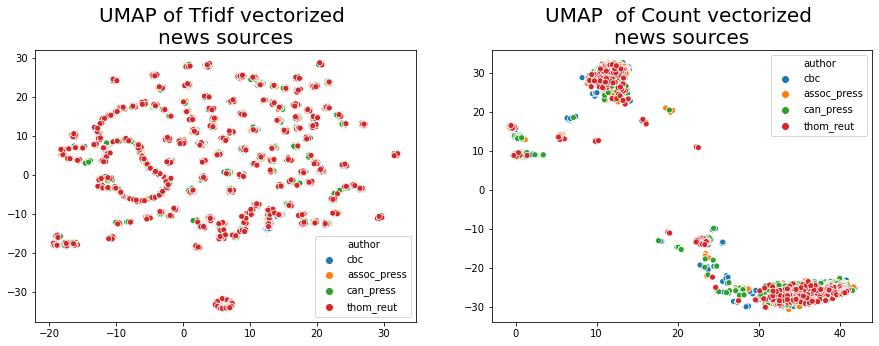

In [655]:


fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
sns.scatterplot(tfumap[:,0], tfumap[:,1], tfY)
plt.title('UMAP of Tfidf vectorized \nnews sources',size = 20)
plt.subplot(1,2,2)
sns.scatterplot(cvumap[:,0], cvumap[:,1], cvY)
plt.title('UMAP  of Count vectorized \nnews sources',size = 20)
plt.show()

In [ ]:
#UMAP patterns are not defined by news sources but there are some distinct groups in the Count vectorized UMAP

In [642]:
from sklearn.cluster import KMeans

In [656]:
#Define cluster labels for UMAP pattern (clearly there are two main ones)
km = KMeans(n_clusters = 4)
km.fit_transform(cvumap)
cvpred = km.fit_predict(cvumap)

In [714]:
#Add cluster labels to check whether sentence length defines these clusters
df_sent['cv_umap_pred'] = cvpred

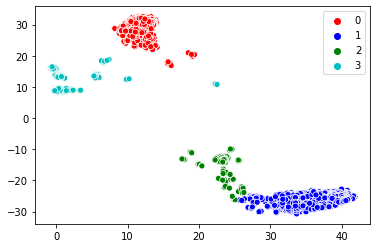

In [712]:
# Label UMAP by kmeans labeled clusters
fig = sns.scatterplot(cvumap[:,0], cvumap[:,1], cvpred, palette = ['r', 'b', 'g', 'c'])
plt.show()

In [717]:
df_sent['sent_length'] = df_tfvec['sent_length']

In [721]:
sent_length_grouped = df_sent.groupby('cv_umap_pred')['sent_length']
sent_length_grouped.mean()

cv_umap_pred
0    45.630814
1    86.495785
2    94.067114
3    57.800995
Name: sent_length, dtype: float64

Conclusions:
1. Tfidf and Count vectorizers did a poor job alone in predicting the news source. This suggests that the word analysis alone does not predict news source (~50% accuracy with logistic regression). Although not shown, adding sentence length did not improve distinction between news sources. This suggests that these features are fairly constant amoung top news sources in Canada. 

2. While sentence length was not included in UMAP dimension reduction, the amount of words for a sentence will become apparent from the amount of 1s that populate rows with either short or long sentences. Therefore it is not that surprising that UMAP labeled with k-means clusters show that theses clusters seem to group by length of sentences (0 and 3 are closer and are the shorter sentences; 1 and 2 are closer and represent the longer sentences). It is interesting that there is such sharp division in sentence length that is consistent among all the new sources.

